In [41]:
%load_ext autoreload
%autoreload 2


In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_dictionary, get_module_img
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)


### Generate population-tree features for each given tree span and gamma parameter

In [ ]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [ ]:
fcm, scm = connectome_average(fc_group, sc_group)

In [ ]:
g = 0.5
for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm, scm)
    tree_min = 17
    tree_max = 22
    t_dict = tree_dictionary(tree_min, tree_max, W)
    json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "w"))
    full_features = []
    for sc, fc in zip(sc_group, fc_group):
        t_features, t_features_names = tree_connectivity(tree_min, tree_max, W, sc, fc)
        full_features.append(t_features)

    full_df = pd.DataFrame(full_features)
    full_df.columns = t_features_names
    full_df = full_df.loc[:, ~full_df.apply(lambda x: x.duplicated(), axis=1).all()].copy()
    full_df.to_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"), index=False)


### Store a nifti of a given module

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import json

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.5.json"), "r").read())
rois = t_dictionary['lvl_20_mod_3']

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
atlas_data = atlas.get_fdata()
atlas_rois = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
atlas_rois_image = nib.Nifti1Image(atlas_rois, affine=atlas.affine)
nib.save(atlas_rois_image, os.path.join(project_path, "craddock_2128_2mm_lvl_20_mod_3.nii.gz"))


### Neuropsychological score prediction using population-tree features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nilearn import plotting
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, GridSearchCV
from scipy import stats
from reg_functions import get_mae_cv, univariate_feature_ranking, iterative_regression, optimal_brain_map
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import kruskal, pearsonr
import seaborn as sns

## CVLT test (verbal memory)

(array([ 1.,  0.,  2.,  3., 13., 15., 21., 22., 33., 26.]),
 array([-7.5229775 , -6.47451775, -5.42605799, -4.37759824, -3.32913848,
        -2.28067873, -1.23221897, -0.18375922,  0.86470054,  1.91316029,
         2.96162005]),
 <BarContainer object of 10 artists>)

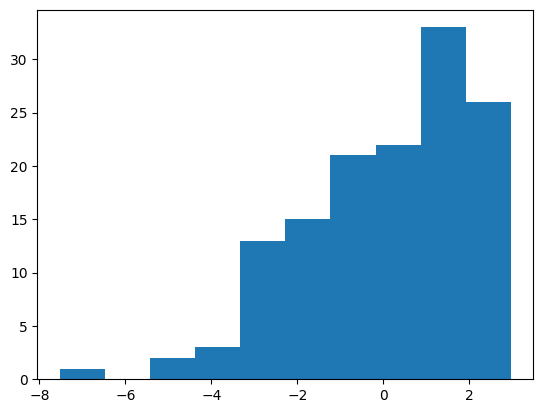

In [50]:
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
plt.hist(y)

#### Only training (cross-validation) using five different linear models

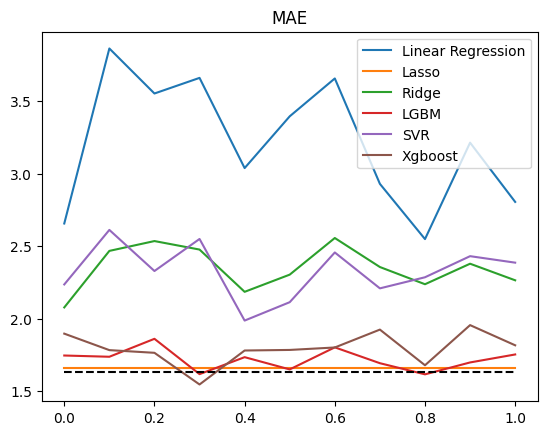

In [43]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
clf_6 = XGBRegressor()

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        mae, mae_std = get_mae_cv(X, y, clf)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()
mae_mean = np.mean(np.abs(y-np.mean(y)))

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

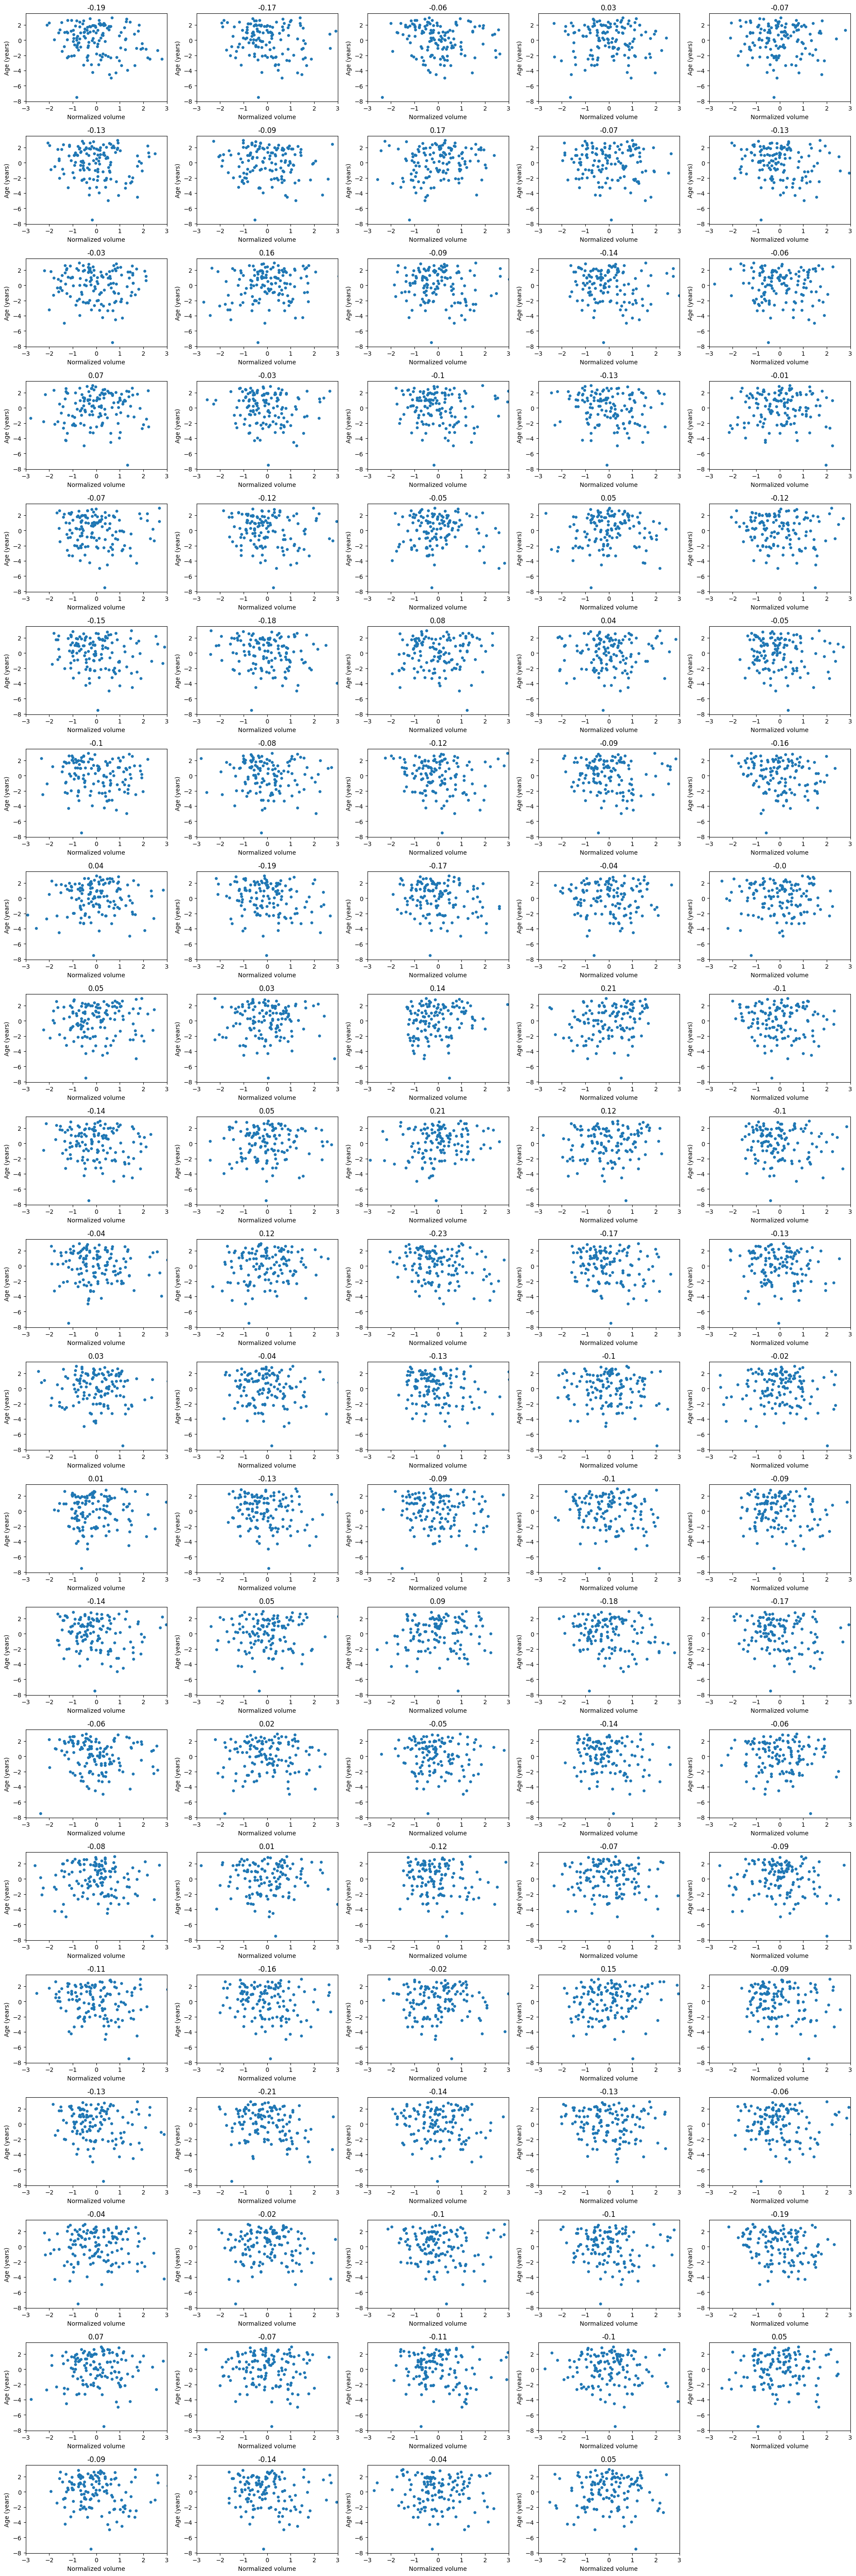

In [26]:
g=0.3
scaler = StandardScaler()

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
features = scaler.fit_transform(df)
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
# Explore relationship between each individual feature and age.
plt.figure(figsize=(20, 60))
valid_feat = []
for d in range (features.shape[1]):
    plt.subplot(21,5,d+1)
    plt.scatter(features[:,d],y,s=15)
    pearson_coeff, _ = pearsonr(features[:, d], y)
    if np.abs(pearson_coeff) > 0.15:
        valid_feat.append(d)
    plt.xlabel('Normalized volume')
    plt.ylabel('Age (years)')
    plt.xlim([-3.0, 3.0])
    plt.title(str(round(pearson_coeff, 2)))
plt.tight_layout()
plt.show()

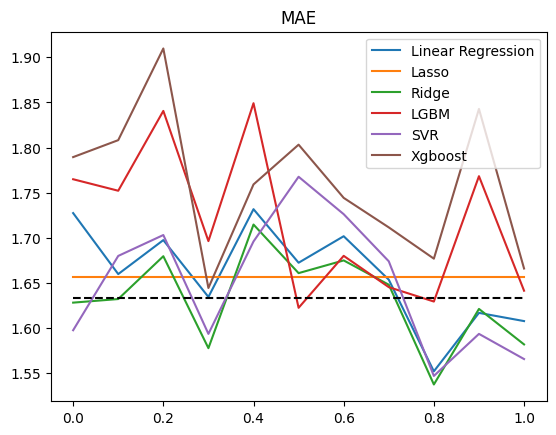

In [48]:
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        valid_feat = []
        r_values = []
        for d in range (X.shape[1]):
            pearson_coeff, _ = pearsonr(X[:, d], y)
            if np.abs(pearson_coeff) > 0.15:
                valid_feat.append(d)
                r_values.append(pearson_coeff)
        good_features = X[:, valid_feat]
        mae, mae_std = get_mae_cv(good_features, y, clf)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

### Using Ridge and rank

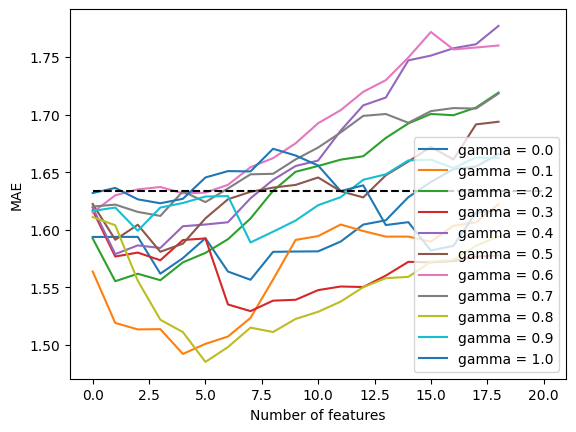

In [19]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
model = Ridge()
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, model, folds=10)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

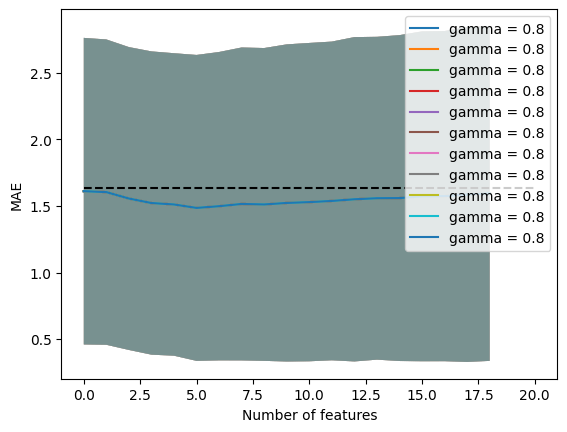

In [3]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
model = Ridge()
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    g = 0.8
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, model, folds=10)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

array([[1.        , 0.31616849],
       [0.31616849, 1.        ]])

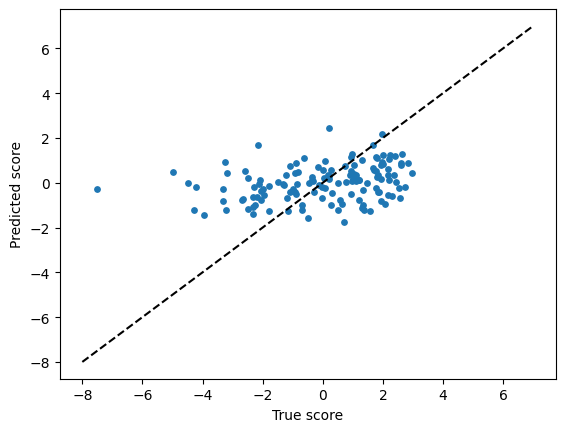

In [4]:
g = 0.8
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
Y_pred = cross_val_predict(model, Xsorted[:,:5], y, cv=10)
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.plot(range(-8, 8), range(-8,8), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

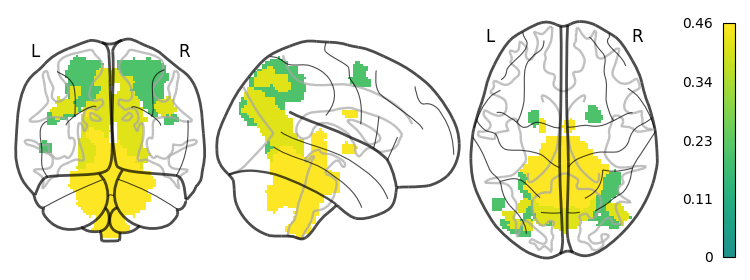

In [8]:
atlas_name = "craddock_2128_2mm.nii.gz"
brainmap = optimal_brain_map(project_path, atlas_name, names_sorted[:5], r_vals_sorted[:5], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')


## TMT test (Attention)

(array([ 1.,  0.,  2.,  6., 10., 21., 40., 30., 20.,  6.]),
 array([-5.1392619 , -4.36324259, -3.58722328, -2.81120397, -2.03518466,
        -1.25916535, -0.48314603,  0.29287328,  1.06889259,  1.8449119 ,
         2.62093121]),
 <BarContainer object of 10 artists>)

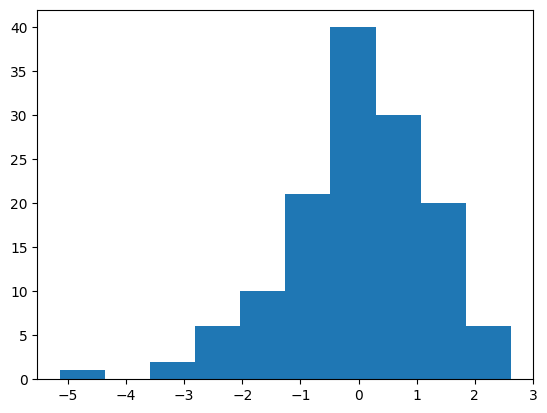

In [10]:
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "TMT",  "TMT_zstuffed.txt"))
plt.hist(y)

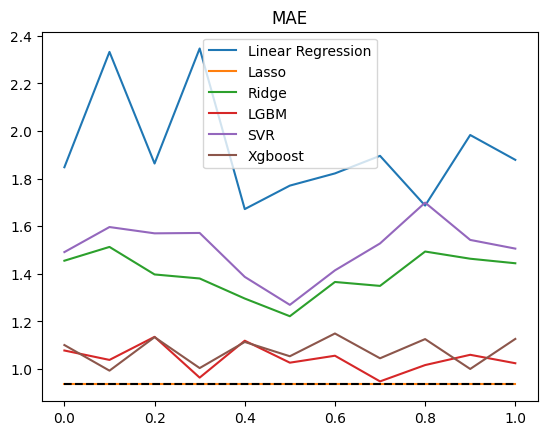

In [11]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
clf_6 = XGBRegressor()

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "TMT",  "TMT_zstuffed.txt"))
scaler = StandardScaler()

for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        mae, mae_std = get_mae_cv(X, y, clf)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()
mae_mean = np.mean(np.abs(y-np.mean(y)))

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

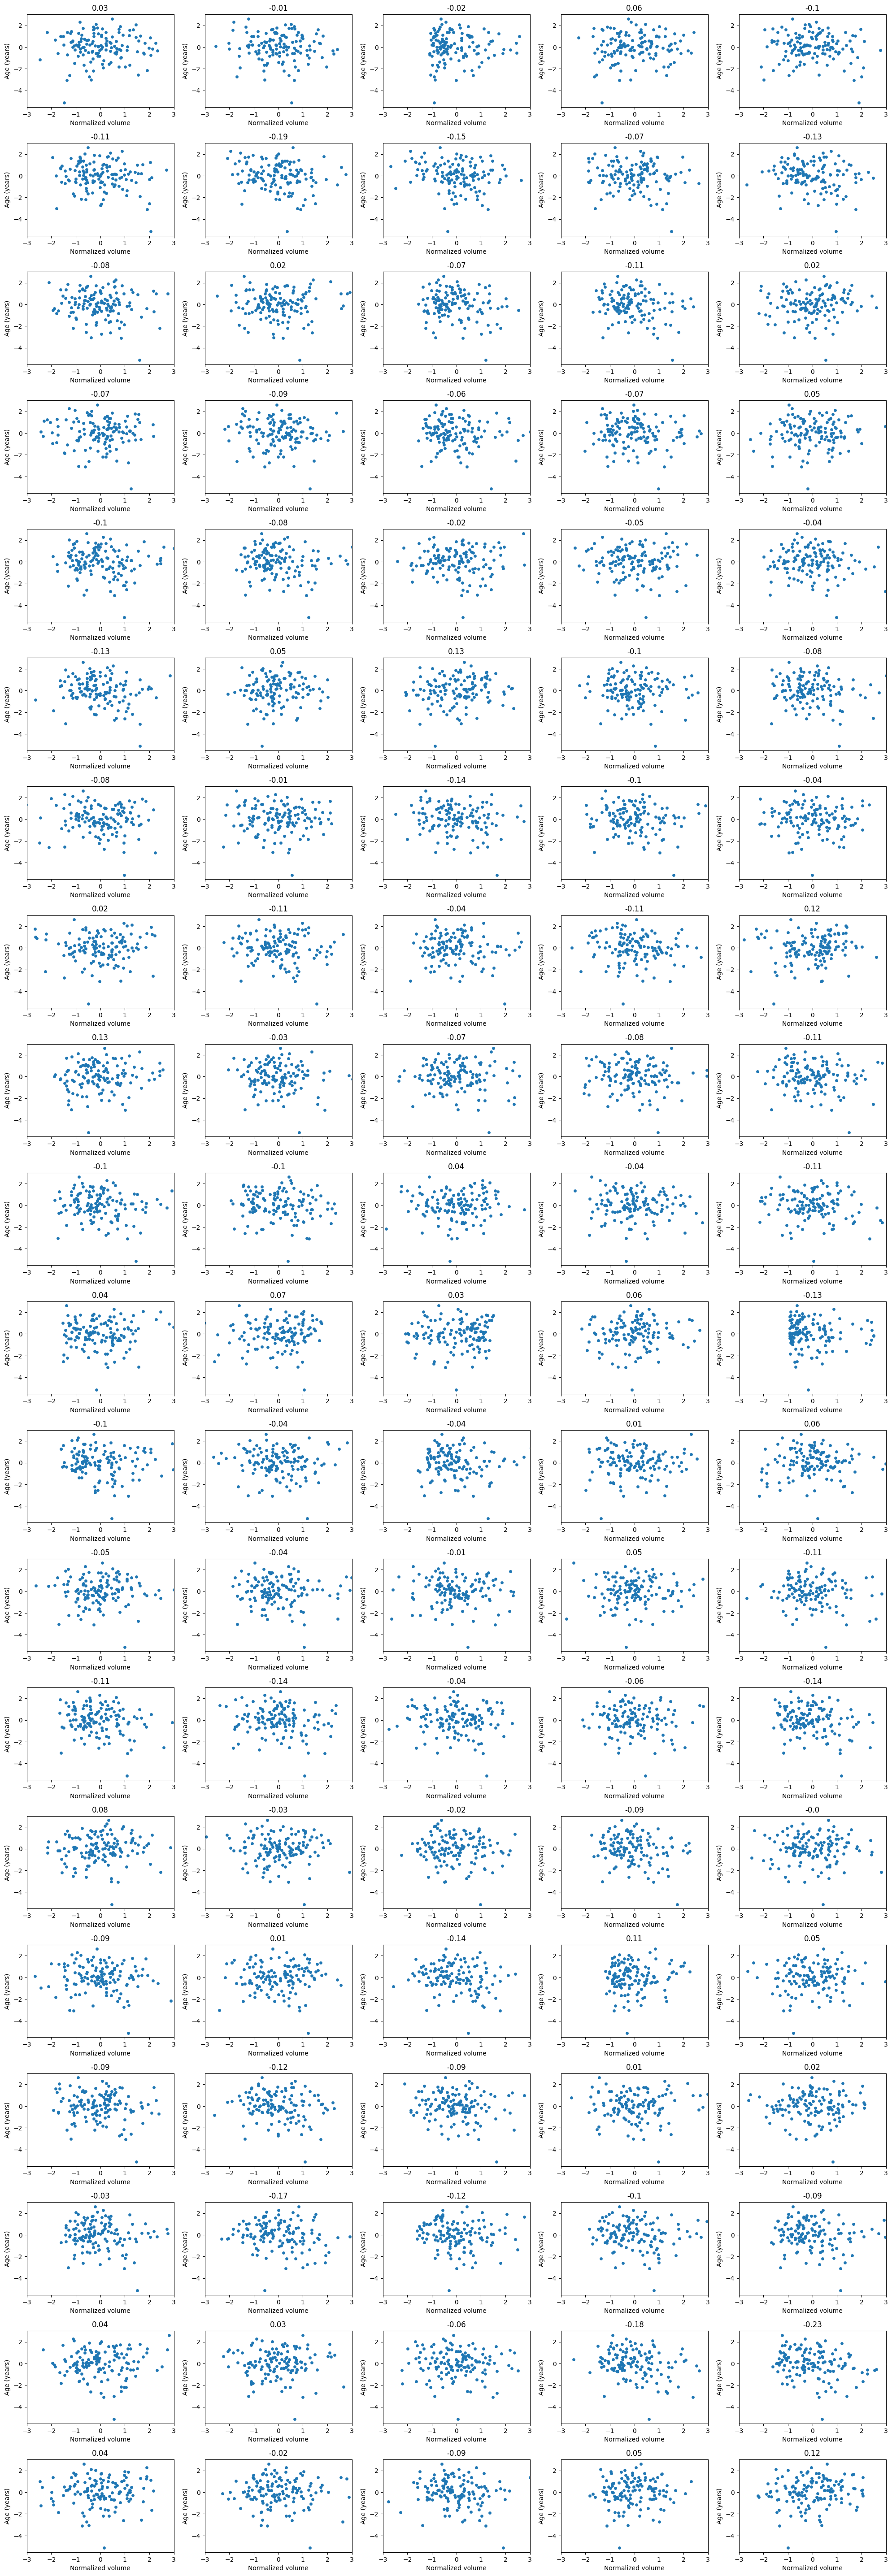

In [12]:
g=0.7
scaler = StandardScaler()

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
features = scaler.fit_transform(df)
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "TMT",  "TMT_zstuffed.txt"))
# Explore relationship between each individual feature and age.
plt.figure(figsize=(20, 60))
valid_feat = []
for d in range (features.shape[1]):
    plt.subplot(21,5,d+1)
    plt.scatter(features[:,d],y,s=15)
    pearson_coeff, _ = pearsonr(features[:, d], y)
    if np.abs(pearson_coeff) > 0.15:
        valid_feat.append(d)
    plt.xlabel('Normalized volume')
    plt.ylabel('Age (years)')
    plt.xlim([-3.0, 3.0])
    plt.title(str(round(pearson_coeff, 2)))
plt.tight_layout()
plt.show()

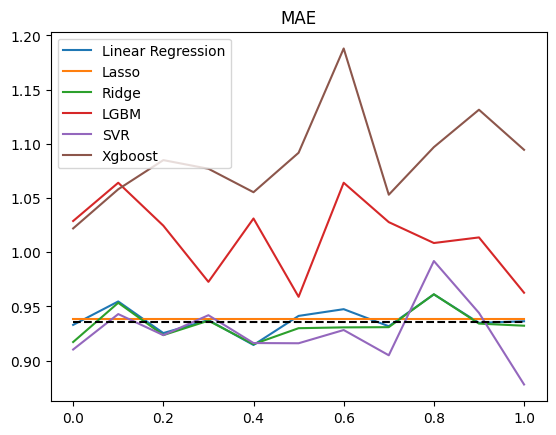

In [13]:
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        valid_feat = []
        r_values = []
        for d in range (X.shape[1]):
            pearson_coeff, _ = pearsonr(X[:, d], y)
            if np.abs(pearson_coeff) > 0.15:
                valid_feat.append(d)
                r_values.append(pearson_coeff)
        good_features = X[:, valid_feat]
        mae, mae_std = get_mae_cv(good_features, y, clf)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

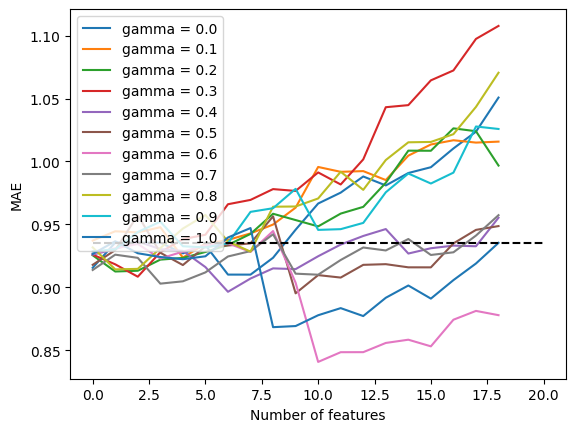

In [14]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
model = SVR(kernel='linear')
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "TMT",  "TMT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, model, folds=10)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

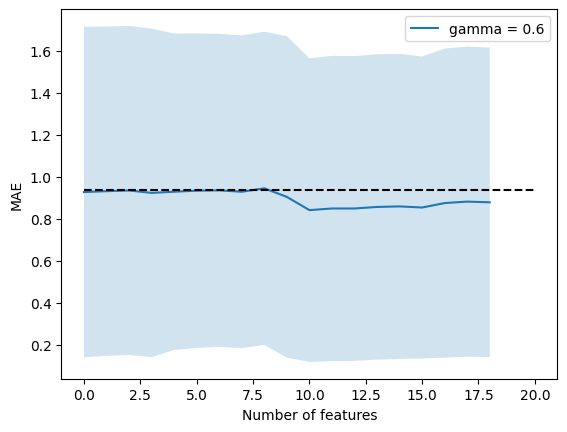

In [15]:

g = 0.6
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
mae_mean, mae_std = iterative_regression(Xsorted, y, 20, model, folds=10)

plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
plt.xlabel("Number of features")
plt.ylabel("MAE")
plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

array([[1.        , 0.25552906],
       [0.25552906, 1.        ]])

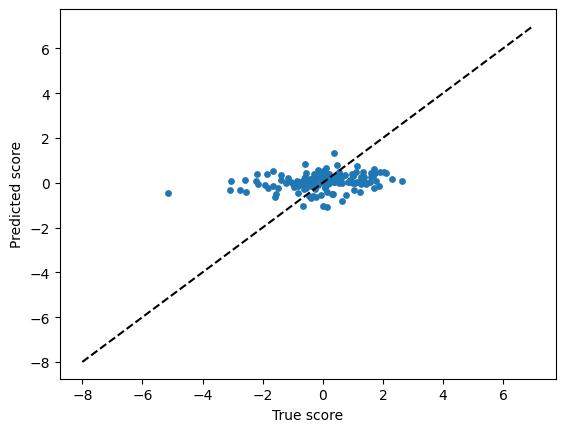

In [16]:
g = 0.6
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
Y_pred = cross_val_predict(model, Xsorted[:,:5], y, cv=10)
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.plot(range(-8, 8), range(-8,8), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

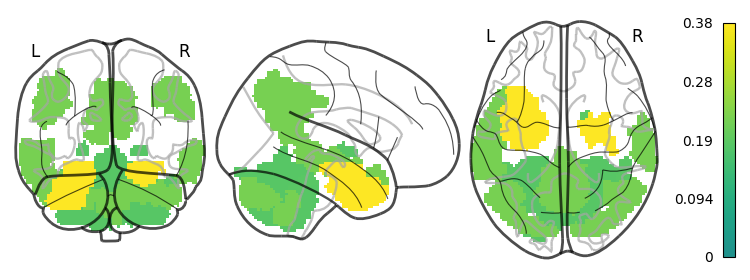

In [17]:
atlas_name = "craddock_2128_2mm.nii.gz"
brainmap = optimal_brain_map(project_path, atlas_name, names_sorted[:5], r_vals_sorted[:5], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')
